# NLE Assignment 1: Books vs DVDs

In this assignment, you will be investigating NLP methods for distinguishing reviews written about books from reviews written about DVDs.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [86]:
candidateno = 215816 #this MUST be updated to your candidate number so that you get a unique data sample


In [87]:
#set up drives for resources.  Change the path as necessary

from google.colab import drive
#mount google drive
drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/My Drive/NLE Notebooks/resources/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [88]:
#do not change the code in this cell
#preliminary imports

#for setting up training and testing data
from sussex_nltk.corpus_readers import AmazonReviewCorpusReader
import random

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
from itertools import zip_longest


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [89]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       
 

def feature_extract(review):
    """
    Generate a feature representation for a review
    :param review: AmazonReview object
    :return: dictionary of Boolean features
    """
    return {word:True for word in review.words()}

def get_training_test_data(categories=('book','dvd'),ratio=0.7,seed=candidateno):
    """
    Get training and test data for a given pair of categories and ratio, pre-formatted for use with NB classifier
    :param category: pair of categories of review corpus, two from ["kitchen, "dvd, "book", "electronics"]
    :param ratio: proportion of data to use as training data
    :return: pair of lists 
    """
    random.seed(candidateno)

    train_data=[]
    test_data=[]
    for category in categories:
      reader=AmazonReviewCorpusReader().category(category)    
      train, test = split_data(reader.documents(),ratio=ratio)
   
      train_data+=[(feature_extract(review),category)for review in train]
      test_data+=[(feature_extract(review),category)for review in test]
    random.shuffle(train_data)
    random.shuffle(test_data)

    return train_data,test_data

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [90]:
#do not change the code in this cell
training_data,testing_data=get_training_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 6526
The amount of testing data is 2799
The representation of a single data item is below
({'We': True, "'ll": True, 'keep': True, 'this': True, 'one': True, 'simple': True, ':': True, "-'Aliens": True, "'": True, 'is': True, 'the': True, 'greatest': True, 'action': True, 'movie': True, 'of': True, 'all-time': True, ',': True, 'and': True, 'it': True, "'s": True, 'not': True, 'a': True, 'bad': True, 'horror': True, 'either': True, '.': True, 'It': True, 'more': True, 'unremittingly': True, 'intense': True, 'movies': True, 'The': True, 'final': True, 'third': True, 'just': True, 'relentless': True, 'even': True, 'various': True, 'slow': True, 'parts': True, 'have': True, 'an': True, 'undeniable': True, 'electricity': True, 'to': True, 'them': True, 'after': True, 'like': True, '10': True, 'viewings': True, 'on': True, 'my': True, 'part': True, 'absolute': True, 'masterpiece': True, 'practical': True, 'special': True, 'effects': True, 'aliens': True, 'thems

1) Use your training data to find
a) the top 20 words which occur more frequently in book reviews than in dvd reviews
b) the top 20 words which occur more frequently in dvd reviews than book reviews
Discuss what pre-processing techniques you have applied (or not applied) in answering this question, and why. [20%]

In [91]:
import nltk
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist
from functools import reduce

def get_book_dvd_training_data(training_data):
  """
    Get book and dvd review training data
    :param training_data: A nested list of dvd and book review data
    :return: pair of lists where the first element of the pair is a list of the book training data and the second is a list of the dvd training data.
    """
  book_train = []
  dvd_train = []
  for (docs,label) in training_data:
    if 'book' in label:
      book_train +=docs.keys()
    else:
      dvd_train +=docs.keys()

  return book_train,dvd_train

def frequent_words_in_book_dvd(book_train,dvd_train):
  """
    Get the words and the number of times certain words occur from the book training data and dvd training data
    :param book_train: A list of book review data
    :param dvd_train: A list of dvd review data
    :return: pair of dictionaries where the first element is a dictionary, where the keys are words occurring in book reviews and the values are the number of times a certain word occurs,
             and the second is a dictionary, where the keys are words occurring in DVD reviews and the values are the number of times a certain word occurs.
    """
  book_train,dvd_train = get_book_dvd_training_data(training_data)
  wl = WordNetLemmatizer()
  lemma_book = [wl.lemmatize(word) for word in book_train]                #Break a word down into it's root word
  lemma_dvd = [wl.lemmatize(word) for word in dvd_train]
  lower_book = [word.lower() for word in lemma_book]                      #Convert all words to lower case
  lower_dvd =  [word.lower() for word in lemma_dvd]
  filter_book = [word for word in lower_book if word.isalpha() and word not in stop]    #Filter the words which solely contain characters and remove the stopwords(the,a,and...)
  filter_dvd = [word for word in lower_dvd if word.isalpha() and word not in stop]
  book_frequ = FreqDist(filter_book)
  dvd_frequ = FreqDist(filter_dvd)
  return book_frequ,dvd_frequ

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [92]:
stop = stopwords.words('english')
book_train,dvd_train = get_book_dvd_training_data(training_data)
book_freqdist,dvd_freqdist = frequent_words_in_book_dvd(book_train,dvd_train)

def top_words_book_dvd(top_words_class_A_compared_to_class_B,class_B,top):
  """
    Get the most frequent words from the book training data and dvd training data
    :param dvd_freqdist: A dicitonary of dvd review data, where the keys are words and the values are the number of times those words occur
    :param book_freqdist: A dicitonary of book review data, where the keys are words and the values are the number of times those words occur
    :param top: The number of top words occuring in both, dvd and book reviews
    :return: A list of the top words, occuring in book reviews or dvd reviews (depends which parameter is entered first)
    """
  difference = [(w,f-class_B.get(w,0)) for (w,f) in top_words_class_A_compared_to_class_B.most_common()]   #Get the most common words in class A (e.g book) reviews, and compare how often these occur in class B (dvd)
  sortediff = sorted(difference,key=lambda pair:pair[1],reverse=True) 
  top_words = [w for (w,f) in sortediff]                         
  return top_words[:top]

In [93]:
top_dvd=top_words_book_dvd(dvd_freqdist,book_freqdist,20)
print("These are the most frequent words in dvd reviews")
print(top_dvd)

top_book=top_words_book_dvd(book_freqdist,dvd_freqdist,20)
print("These are the most frequent words in book reviews")
print(top_book)

These are the most frequent words in dvd reviews
['movie', 'film', 'dvd', 'watch', 'one', 'scene', 'great', 'wa', 'see', 'like', 'show', 'get', 'love', 'time', 'good', 'watching', 'seen', 'performance', 'actor', 'ha']
These are the most frequent words in book reviews
['book', 'read', 'author', 'reading', 'reader', 'page', 'writing', 'novel', 'written', 'chapter', 'information', 'example', 'business', 'history', 'recipe', 'research', 'topic', 'idea', 'description', 'subject']


To find the 20 most frequent words in dvd and book reviews, we must first get all of the tokens which occur in both dvd and book reviews from the training data.

**Note** that the training data is represented as a nested list(document,label) where in the document(represented as a dicitonary) every key is a token; the review data has been **tokenized** (a pre-processing technique, where the tokens are separated by whitespace in the review string, and have been imputed into a list), followed by the value true. Label is the class a document belongs to, it is either dvd or book.

To separate the book and dvd review data from the training data we run a loop around the entire training data, and separate it into a list of words occuring in book reviews and a list of words occuring in dvd reviews. To acquire the words, we use the label from the training data to categorize the words into different classes (dvd or book).

Then, we call a method called FreqDist to get how often do the tokens occur in each of our classes.

Finally we get the tokens which occur more frequently in one class than the other, and return the top 20 words occuring in each class.

The pre processing techniques were used when putting all of the words from the reviews into lists. The techniques chosen were **case normalisation**, because by setting all words to lower case, the frequency of certain words occuring increases,**number removal** because we want to get the most frequent words, not numbers and **punctuation and stopword removal** because they occur very frequently in all documents, which doesn't help us in finding which words occur more in one document or the other. **Lemmatisation** was also used, because it increases the frequency of a particular word (it removes the affixes, number, gender etc.). **Stemming was not used**, as it can produce errors of commission, e.g organization does not derive to organ, which is what stemming would do. **Sentence segmentation was not used**, as when the training data was created, all of the words in every review where split into single tokens instead of sentences.Also, **Number normalisation was not used**, as we are only interested in the most frequent words, not numbers (we remove the numbers, see number removal). In addition to that, **alphabetical ordering** was not used either, as we are not interested in ordering the words from the reviews alphabetically.

2) Design, build and test a word list classifier to classify reviews as being from the book domain or from the dvd domain.  Make sure you discuss 1) how you decide the lengths and contents of the word lists and ii) accuracy, precision and recall of your final classifier.[30%]

In [94]:
from nltk.classify.api import ClassifierI  
import random
# Classifier class. This class is used to classify documents into book reviews and dvd reviews
#Initialise the class, with the most frequent words in book and dvd reviews
    #:param self: Represents instance of the class
    #:param dvd: A list of the most frequent words in dvd reviews
    #:param book: A list of the most frequent words in book reviews
class Simple_classifier_dvd_book(ClassifierI):
  def __init__(self,dvd,book):
    self._dvd = dvd
    self._book = book

  def classify(self, words):
    """
    Classifies if a list of words belongs to the book reviews or dvd reviews
    :param self: Represents instance of the class
    :param words: A list of strings
    :return: If the words that appear in the list also appear in the most frequent words in dvd reviews, return "dvd"
             else if the words that appear in the list also appear in the most frequent words in book reviews, return "book".
             If the list does not belong to neither book or dvd reviews, return "book".
    """
    score = 0
    for word in words:
      if word in self._book:
        score = score + 1
      if word in self._dvd:
        score = score-1
    if score == 0:                    #If classifier doesn't know to which class a review belongs to, it takes a guess
      score = random.choice((-1,1))
    return "dvd" if score < 0 else "book"   



In [95]:
#An extension of the Classifier_dvd_book. Here we implement a method for the classifier to train on some training data.
#The size of the training data is what the user desires.
#Initialises the class with an integer
    #:param self: Represents instance of the class
    #:param k: The number of reviews the user want to input
class BinaryClassifier(Simple_classifier_dvd_book):

  def __init__(self,k):
    self._k = k

  def train(self,training_data):
    """
    Trains the classifier with a certain amount of training data (what the user specified)
    :param self: Represents instance of the class
    :param training_data: A list of dvd and book review data
    """
    book_train,dvd_train = get_book_dvd_training_data(training_data)
    book_freqdist,dvd_freqdist = frequent_words_in_book_dvd(book_train,dvd_train)
    self._dvd = top_words_book_dvd(dvd_freqdist,book_freqdist,self._k)
    self._book = top_words_book_dvd(book_freqdist,dvd_freqdist,self._k)

In [96]:
def classifier_accuracy(classifier,testing_data):
  """
    Calculates how accurate is the classifier when labelling if a review belongs to a dvd review or book review
    :param classifier: Either a BinaryClassifier from the Binary Classifier class or an Naïve Bayes Classifer from the NBclass
    :param testing_data: A list of dvd and book review data
    """
  acc = 0
  for (doc,label) in testing_data:
    if classifier.classify(doc) in label:
      acc+=1
    else:
      0
  return acc / (len(testing_data) + 0.0) 

def get_predictions(classifier):
  """
    Get what the classifier has predicted of the review testing data
    :param classifier: Either a BinaryClassifier from the Binary Classifier class or an Naïve Bayes Classifer from the NBclass
    """
  pred = []
  for (doc,label) in testing_data:
    pred += classifier.classify(doc).split()
  return pred

def get_goldstandards(classifier):
  """
    Get what the actual label (book or dvd) from the testing data
    :param classifier: Either a BinaryClassifier from the Binary Classifier class or an Naïve Bayes Classifer from the NBclass
    """
  true = []
  for (doc,label) in testing_data:
    true += label.split()
  return true

In [97]:
#Set up a confusion matrix, to check what the True positives, False positives, False negatives and True Negatives for the predicitions and goalstandards
#Initialise the class, with the predicitons, goalstandards and classes of the reviews
    #:param self: Represents instance of the class
    #:param predicitions: A list of the classes of reviews predicited by the classifier
    #:param goldstandards: A list of the classes of reviews, which are 100% accurate
    #:param classes: A pair of strings, specifying the classes "book" and "dvd"
class ConfusionMatrix:
    def __init__(self,predictions,goldstandard,classes=("book","dvd")):
        (self.c1,self.c2)=classes
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
        for p,g in zip(predictions,goldstandard):
            if g==self.c1:
                if p==self.c1:
                    self.TP+=1
                else:
                    self.FN+=1
            
            elif p==self.c1:
                self.FP+=1
            else:
                self.TN+=1
    
    def precision(self):
      """
      Calculates how precise was the classifier when predicting the class
    :param self: Represents instance of the class
    """
      p=0
      p = self.TP/(self.TP+self.FP)
      return p
    
    def recall(self):
      """
      Calculates the recall of the classifier
    :param self: Represents instance of the class
    """
      r=0
      r = self.TP/(self.TP+self.FN)
      return r

    def final_score(self):
      """
      Calculates the final score of the classifier
    :param self: Represents instance of the class
    """
      f1 = 0
      f1 = 2*(self.TP/(self.TP+self.FP))*(self.TP/(self.TP+self.FN))/(self.TP/(self.TP+self.FP)+self.TP/(self.TP+self.FN))
      return f1

In [98]:
dvd_book_classifier = BinaryClassifier(20)
dvd_book_classifier.train(training_data)
print("This is the classifier's accuracy: {}".format(classifier_accuracy(dvd_book_classifier,testing_data)))
confusion = ConfusionMatrix(get_predictions(dvd_book_classifier),get_goldstandards(dvd_book_classifier))
print("This is the classifier's precision: {}".format(confusion.precision()))
print("This is the classifier's recall: {}".format(confusion.recall()))
print("This is the classifier's final score: {}".format(confusion.final_score()))


This is the classifier's accuracy: 0.8152911754197928
This is the classifier's precision: 0.8738317757009346
This is the classifier's recall: 0.6498696785403997
This is the classifier's final score: 0.7453911310413553


The classifier has been designed in the following way: The Simple_classifier_dvd_book class, is not trained on data, it just asks for a word list of dvd and book reviews (from exercise 1 input top book and dvd review words) and then classifies a list of words into the dvd class, if the list contains words from the top dvd review list, otherwise it will classify it in the book class if the list contains words from the top book review list. If the list does not contain words from neither of the classes, than the classifier classifies the list into a class at random.
The Binary class classifier, is an extension of the Simple_classifier_dvd_book, which trains on a certain amount of the training data (the user inputs a number, which is the amount of training data that the classifier uses), or in other words, it gets the most common n words, n being the number inputed by the user, from book reviews and dvd reviews.




For deciding the content and length of the wordlist. The user, inputs the top words occuring in book and dvd reviews, back from excercise 1, and from those list, the user decides how many words from the most frequent words in book and dvd reviews should be included when classifying documents, e.g if the user inputs 20, then the wordlist will contain the top 20 words ocurring in dvd reviews and book reviews. **Note** we decide it is best to use around 20 words for the wordlist, because if there are too many words, like 100, the classifier will have a hard time classifying documents, as the word list for most frequent words in dvd reviews and book reviews will have words which occur in both reviews.

Discussing the results of our classifier, we can see that it is quite accurate (correct predictions over the length of the testing data) and precise (the proportion of a class (in this case "book") predictions that are correct). But the recall is about 65% (is the proportion of actually class (in this case "book") documents that are predicted correctly), meaning that to improve it, we have to reduce the number of false negatives (Document labeled to the class we want, but predicted as being of the other class). Still, our final score 75% which is quite good, because it means that are precision and recall is actually quite high.

3) Compare the performance of your word list classifier with a Naive Bayes classifier (e.g., from NLTK).  Make sure you discuss the results. [20%]

In [99]:
#Reason I havent imported the Naïve Bayes classifier from utils, is because the assigment specifies that our own code should be included in the notebook rather than imported from elsewhere
#This code is not commented, as it is imported from the utils file, nothing has been changed except for the labels, from positive to book and negative to dvd

import math
class NBClassifier(ClassifierI):
    
    def __init__(self):
        self._labels=["dvd","book"]
        pass
    
    def labels(self): 
        return self._labels
    
    def set_known_vocabulary(self,training_data):
        known=[]
        for doc,label in training_data:
            known+=list(doc.keys())
        self.known= set(known)
    
    def set_priors(self,training_data):
        priors={}
        for (doc,label) in training_data:
            priors[label]=priors.get(label,0)+1
        total=sum(priors.values())
        for key,value in priors.items():
            priors[key]=value/total
        self.priors=priors
        
    def set_cond_probs(self,training_data):
        conds={}
        for(doc,label) in training_data:
            classcond=conds.get(label,{})
            for word in doc.keys():
                classcond[word]=classcond.get(word,0)+1
        
            conds[label]=classcond
    
        for label, classcond in conds.items():
            for word in self.known:
        
                classcond[word]=classcond.get(word,0)+1
            conds[label]=classcond
            
        for label,dist in conds.items():
            total=sum(dist.values())
            conds[label]={key:value/total for (key,value) in dist.items()}
        
        self.conds=conds
    
    def train(self,training_data):
        self.set_known_vocabulary(training_data)
        self.set_priors(training_data)
        self.set_cond_probs(training_data)
    
    def classify(self,doc):
        doc_probs={key:math.log(value) for (key,value) in self.priors.items()}
        for word in doc.keys():
            if word in self.known:
                doc_probs={classlabel:sofar+math.log(self.conds[classlabel].get(word,0)) for (classlabel,sofar) in doc_probs.items()}

        highprob=max(doc_probs.values())
        classes=[c for c in doc_probs.keys() if doc_probs[c]==highprob]
        return random.choice(classes)

In [100]:
nb = NBClassifier()
nb.train(training_data)

In [101]:
nbc = ConfusionMatrix(get_predictions(nb),get_goldstandards(nb))

print("This is the NBclassifier's accuracy: {}".format(classifier_accuracy(nb,testing_data)))
print("This is the NBclassifier's recall: {}".format(nbc.recall()))
print("This is the NBclassifier's precision: {}".format(nbc.precision()))
print("This is the NBclassifier's final score: {}".format(nbc.final_score()))

This is the NBclassifier's accuracy: 0.9389067524115756
This is the NBclassifier's recall: 0.8922675933970461
This is the NBclassifier's precision: 0.9562383612662942
This is the NBclassifier's final score: 0.9231460674157304


The Naïve Bayes classifier, uses all of the training data, that is to say, it gets all of the tokens from the training data, unlike our Binary classifier, which only gets a certain amount of training data which is specified by the user. From that training data, the Naïve Bayes classifier sets up class priors, which sets up the probability of a document being in either class dvd reviews or book reviews, it also sets up the conditional probabilities, which are the probabilities of a certain word ocurring in a certain class document, e.g the probability of seeing book in a book reviews document.

Discussing the results of our Naïve Bayes classifier. We can see it has 93% accuracy, meaning it almost always predicts the label correctly. It has a 89% recall, the proportion of actually class (in this case "book") documents that are predicted correctly and a 95% precision the proportion of a class (in this case "book") predictions that are correct. As the Naïve Bayes classifier has a high precision and recall, we can imply that the final score will also be high; 92%.

4) Design and carry out an experiment into the impact of the amount of training data on each of these classifiers.  Make sure you describe design decisions in your experiment, include a graph of your results and discuss your conclusions. [30%] 

The accuracy of Binary classifier is 0.82 for training data size 6
The precision of Binary classifier is 0.87 for training data size 6
The recall of Binary classifier is 0.64 for training data size 6 

The accuracy of Naïve Bayes classifier is 0.59 for training data size 6
The precision of Naïve Bayes classifier is 1.0 for training data size 6
The recall of Naïve Bayes classifier is 0.0 for training data size 6 

The accuracy of Binary classifier is 0.81 for training data size 10
The precision of Binary classifier is 0.87 for training data size 10
The recall of Binary classifier is 0.64 for training data size 10 

The accuracy of Naïve Bayes classifier is 0.59 for training data size 10
The precision of Naïve Bayes classifier is 0.91 for training data size 10
The recall of Naïve Bayes classifier is 0.01 for training data size 10 

The accuracy of Binary classifier is 0.82 for training data size 100
The precision of Binary classifier is 0.88 for training data size 100
The recall of Binar

,Name of classifier and amount of training data,Accuracy,Precision,Recall
0,Binary classifier with size of training data 6,0.82,0.87,0.64
1,Naïve Bayes classifier with size of training d...,0.59,1.00,0.00
2,Binary classifier with size of training data 10,0.81,0.87,0.64
3,Naïve Bayes classifier with size of training d...,0.59,0.91,0.01
4,Binary classifier with size of training data 100,0.82,0.88,0.65
5,Naïve Bayes classifier with size of training d...,0.66,0.99,0.16
6,Binary classifier with size of training data 400,0.82,0.88,0.63
7,Naïve Bayes classifier with size of training d...,0.90,0.94,0.80


(0.0, 1.0)

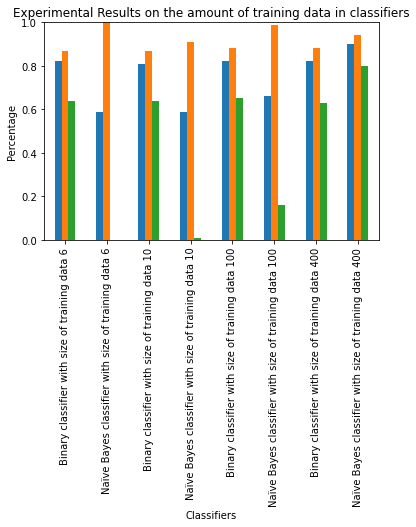

In [103]:
from random import sample
samples = [6, 10, 50, 100, 200, 400, 600, 700]

classifiers={"Binary classifier":BinaryClassifier(20),
             "Naïve Bayes classifier": NBClassifier()}

use=["Binary classifier","Naïve Bayes classifier"]

results = []
sample_size = random.sample(samples,4)
for s in sample_size:
  for name,classifier in classifiers.items():
    if name in use:
      classifier.train(training_data[:s])
      accuracy=classifier_accuracy(classifier,testing_data)
      cn = ConfusionMatrix(get_predictions(classifier),get_goldstandards(classifier))
      precision = cn.precision()
      recall = cn.recall()
      print("The accuracy of {} is {} for training data size {}".format(name,round(accuracy,2),s))
      print("The precision of {} is {} for training data size {}".format(name,round(precision,2),s))
      print("The recall of {} is {} for training data size {} \n".format(name,round(recall,2),s))
      results.append((name+" with size of training data "+str(s),round(accuracy,2),round(precision,2),round(recall,2)))
             
df = pd.DataFrame(results,columns= ["Name of classifier and amount of training data","Accuracy","Precision","Recall"])
display(df)
ax = df.plot.bar(title="Experimental Results on the amount of training data in classifiers",legend=False,x=0)
ax.set_ylabel("Percentage")
ax.set_xlabel("Classifiers")
ax.set_ylim(0,1.0)


In [104]:
from random import sample
samples = [1, 10, 50, 100, 200, 400, 600, 700]

classifiers={"Binary classifier":BinaryClassifier(20),
             "Naïve Bayes classifier": NBClassifier()}

use=["Binary classifier","Naïve Bayes classifier"]

results = []
sample_size = random.sample(samples,4)
for s in sample_size:
  for name,classifier in classifiers.items():
    if name in use:
      classifier.train(training_data[:s])
      cn = ConfusionMatrix(get_predictions(classifier),get_goldstandards(classifier))
      results.append((name+"'s size of training data "+str(s),cn.TP,cn.FP,cn.TN,cn.FN))
             
df = pd.DataFrame(results,columns= ["Name of classifier and amount of training data","True positives","False Positives","True Negatives", "False Negatives"])
display(df)

,Name of classifier and amount of training data,True positives,False Positives,True Negatives,False Negatives
0,Binary classifier's size of training data 400,737,104,1544,414
1,Naïve Bayes classifier's size of training data...,916,56,1592,235
2,Binary classifier's size of training data 10,734,104,1544,417
3,Naïve Bayes classifier's size of training data 10,10,1,1647,1141
4,Binary classifier's size of training data 700,737,111,1537,414
5,Naïve Bayes classifier's size of training data...,960,51,1597,191
6,Binary classifier's size of training data 100,747,107,1541,404
7,Naïve Bayes classifier's size of training data...,188,2,1646,963


These experiments are designed to see the impact on training data on Binary and Naïve Bayes classifiers, the amount of training data is chosen randomly, from the random.sample() function as we can see above.

If we look at the precision and the recall of the Binary classifier when a big amount of training data is imputed, the precision is quite high, but the recall is low. The reason for this is because for the precision, it is reducing the number of **False positives**, because it is not predicting our desired class("book") as much, the goldstandard being the other class ("dvd"), however, as it is not predicting our desired class as much it is increasing the number of **False negatives** (goldstandard being "book", but predicition "dvd" which makes the recall smaller. If we imput less training data the opposite happens, the number of **False positives** increases and reduces the number of **False negatives**.

For the Naïve Bayes classifier, we see that the amount of training data has a great impact on its accuracy, the lesser the training data the less accurate. This occurs because the Naïve Bayes classifier relies heavily on the probabilities of words occuring in a particular class document, with little training data, the Naïve Bayes classifier has a smaller vocabulary and can't tell wether a document belongs to the book or dvd class, unless the document contains words which appear in the Naïve Bayes classifier very limited vocabulary. For the precision and the recall, the reason the precision is so high when little training data is used is because the number of **False positives** is 0, because it has not predicted our desired class ("book") at any moment the goldstandard being the other class ("dvd"), still, the number of **False negatives** is reasonably high, meaning the recall is going to be very small. Unlike Binary classifiers, Naïve Bayes classifiers have high precision and high recall when lots of training data is used, because the number of **True positives** is increasing, which means that the more the training data, the more the classifier predicts correctly the desired class (in this case "book)

In conclusion, we can argue the more training data, the more precision and lesser recall, and the lesser the training data, the more recall and less precision. We have also concluded that the performance of the naïve bayes classifier has the best accuracy and final score, if it has trained from a big amount of training data.

In [105]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of 388

import io
from nbformat import current

filepath="/content/drive/My Drive/NLE Notebooks/NLE assignment/NLEassignment1.ipynb"
question_count=388

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Submission length is 1530


In [106]:
print("The length of the coursework is {} words".format(word_count-question_count))

The length of the coursework is 1530 words
